# Set

In [67]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import platform
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from PIL import Image
from wordcloud import WordCloud

# Load Data

In [2]:
path = "../data/general.csv"
df = pd.read_csv(path, sep = ',', encoding = 'utf-8', header = 0)
df.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0,기능/효과,올 겨울은 촉촉하게 보내고 있어 좋습니다.,6,1
1,660038,발림성 좋습니다. 지속력 좋네요. 건조해진 입술 살짝 발라줬는데 금방 촉촉해져서 좋...,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,86,20,20171121,1.0,발림성,발림성 좋습니다.,2,1
2,660044,양이 작아서 금방 쓰겠어요. 보습력도 별로고요. 배송은 빨랐어요. 재구매는 안 할래요.,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,4,48,11,20171110,-1.0,용량/개수,양이 작아서 금방 쓰겠어요.,4,-1
3,660055,추워지면 늘 입술이 갈라져서 사봤는데 촉촉함이 오래 안가요. 양도 너무 작구요.,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,44,11,20170911,-1.0,지속력/유지력,촉촉함이 오래 안가요.,3,-1
4,660060,입소문 듣고 처음 구매해 봤는데 배송이 빨라서 좋았어요. 지금 발라보니 번들거리긴 ...,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,4,59,14,20170824,-1.0,흡수력,번들거리긴 합니다.,2,-1


In [3]:
df = df.drop(['Aspect', 'SentimentText', 'SentimentWord', 'SentimentPolarity'], axis=1)
df.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity
0,660023,"인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...",쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,88,20,20180205,1.0
1,660038,발림성 좋습니다. 지속력 좋네요. 건조해진 입술 살짝 발라줬는데 금방 촉촉해져서 좋...,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,86,20,20171121,1.0
2,660044,양이 작아서 금방 쓰겠어요. 보습력도 별로고요. 배송은 빨랐어요. 재구매는 안 할래요.,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,4,48,11,20171110,-1.0
3,660055,추워지면 늘 입술이 갈라져서 사봤는데 촉촉함이 오래 안가요. 양도 너무 작구요.,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,5,44,11,20170911,-1.0
4,660060,입소문 듣고 처음 구매해 봤는데 배송이 빨라서 좋았어요. 지금 발라보니 번들거리긴 ...,쇼핑몰,화장품,메이크업/뷰티소품,OO 립 크림 1.5g 1개,4,59,14,20170824,-1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158119 entries, 0 to 158118
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Index            158119 non-null  int64  
 1   RawText          158119 non-null  object 
 2   Source           158119 non-null  object 
 3   Domain           158119 non-null  object 
 4   MainCategory     158119 non-null  object 
 5   ProductName      158114 non-null  object 
 6   ReviewScore      158119 non-null  int64  
 7   Syllable         158119 non-null  int64  
 8   Word             158119 non-null  int64  
 9   RDate            158119 non-null  int64  
 10  GeneralPolarity  144408 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 13.3+ MB


In [5]:
# 결측치 삭제
df = df[df['GeneralPolarity'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144408 entries, 0 to 158118
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Index            144408 non-null  int64  
 1   RawText          144408 non-null  object 
 2   Source           144408 non-null  object 
 3   Domain           144408 non-null  object 
 4   MainCategory     144408 non-null  object 
 5   ProductName      144403 non-null  object 
 6   ReviewScore      144408 non-null  int64  
 7   Syllable         144408 non-null  int64  
 8   Word             144408 non-null  int64  
 9   RDate            144408 non-null  int64  
 10  GeneralPolarity  144408 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 13.2+ MB


In [6]:
df['GeneralPolarity'].value_counts().sort_index()

-1.0    22899
 0.0    29723
 1.0    91786
Name: GeneralPolarity, dtype: int64

In [7]:
df['ReviewScore'].value_counts().sort_index()

0         86
1        931
2        462
3       2669
4      11232
5      71561
10       952
20      1238
30       356
40      1187
50       896
60      3315
70      1733
80      6488
90       781
100    40521
Name: ReviewScore, dtype: int64

In [8]:
df['Syllable'].describe()

count    144408.000000
mean         80.057829
std          41.376395
min           8.000000
25%          53.000000
50%          70.000000
75%          96.000000
max         550.000000
Name: Syllable, dtype: float64

In [9]:
df['Word'].describe()

count    144408.000000
mean         18.172650
std           9.791787
min           1.000000
25%          12.000000
50%          16.000000
75%          22.000000
max         146.000000
Name: Word, dtype: float64

# X,Y train/test split

In [10]:
from sklearn.model_selection import train_test_split

y = df['GeneralPolarity']
y

0         1.0
1         1.0
2        -1.0
3        -1.0
4        -1.0
         ... 
158114    0.0
158115    1.0
158116    0.0
158117    1.0
158118    1.0
Name: GeneralPolarity, Length: 144408, dtype: float64

In [11]:
X = df['RawText']
X

0         인생템입니다. 겨울이면 맨날 입술 트고 갈라지고 장난아닌데, 올 겨울은 촉촉하게 보...
1         발림성 좋습니다. 지속력 좋네요. 건조해진 입술 살짝 발라줬는데 금방 촉촉해져서 좋...
2          양이 작아서 금방 쓰겠어요. 보습력도 별로고요. 배송은 빨랐어요. 재구매는 안 할래요.
3              추워지면 늘 입술이 갈라져서 사봤는데 촉촉함이 오래 안가요. 양도 너무 작구요.
4         입소문 듣고 처음 구매해 봤는데 배송이 빨라서 좋았어요. 지금 발라보니 번들거리긴 ...
                                ...                        
158114     핑크색상이 매우 예뻐서 만족해요 사이즈가 너무 아담해서 타자치기 살짝 답답해서 아쉽네요
158115    화이트샀는데 너무 깔끔하고 좋아요 그리고 컴팩트한 사이지가 너무 귀여워서 좋아요 블...
158116             블루투스 페어링이 잘 연결이 안되서 불편해요. 디자인은 깔끔하니 좋아요.
158117               무게가 굉장히 가벼워서 좋구요. 이동하면서 사용할 수 있어 편리해요.
158118    키보드 자판이 둥글게 생겨서 너무 예뻐요 그리고 자판이 패여서 타자칠때 또각또각 감...
Name: RawText, Length: 144408, dtype: object

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# test_size=0.2의 근거가 필요할까?

(115526,) (28882,) (115526,) (28882,)


In [14]:
X_train

31503                가볍고   따뜻하고   저렴한  가격에  조끼까지.. 완존 득테이네요
2976      맨날 남들 쓰는것만 보다가 엄마가 써보고싶다고해서 구매했는데 구성도 좋고 생각보다 ...
75567     전 주로 영상만 볼거라 화질좋고 볼만해요. 필기할때  화면에 글을 쓰면 톡톡거리는 ...
152901        좋은 상품 좋은 가격에 잘 샀어요 가죽이 부드럽고 촉감등 기대이상입니다 감사합니다
57565     팔길이가 너~~~무 길어요 그래서 별하나 뺐습니다 저두 팔 짧은편이 아닌 사람인데 ...
                                ...                        
121097    큼직한 화면이 보기에 편해서 좋구요~한 손에 들어오는 그립감 또한 만족합니다!! 배...
19847     제품 받자마자 컬러가 너무 이뻐서 감동이였어요. 그런데 이제는 충전기나 그외 구성품...
43382     소음이 너무 심해요.. 소리에 예민하시면  고민하셔야해요 ㅠㅠ  그냥 가격대비  쓸...
109655    정수리 간편하게 커버할수있을거같아서 구입했네요 써보니깐 사용하기 간편하고 머리숱이 ...
90990     제습이 잘돼 침구류도 뽀송해져서 만족합니다. 거실 제습할땐 속도가 느려 시간이오래 ...
Name: RawText, Length: 115526, dtype: object

In [31]:
X_test

275       사은품이 있어 너무 맘에 듭니다. 맵핑 기능이 없어 청소 시키는거 불편합니다. 구석...
36756     쿨맥스데님3종 망설이다 주문했는데 완전맘에들어요.. 청바지를 좋아하는 60대입니다 ...
75207     다른 오일은 너무 따갑고 제피부에 안 맞았는데 이건 예민한 피부에도 순해서 너무 좋...
43463     플라스틱 부분에  마감이 매끄럽지 않고 살짝 움푹 들어가 있는 부분도 있어요 기능에...
62139     이 제품 구하기 힘든 색상으로 주문했는데 예쁘고 너무 좋아요. 그런데 펜은 별도로 ...
                                ...                        
62561      저렴하게 산거 같아서 만족스럽구요. 제가 살때는 사은품이 없었는데 생겨서 좀 아쉽네요ㅠ
133383                          속도 빠르고 정말 좋아요 터치감도 좋고 가볍네요~
128291    제품에 과열방지기능도 포함되어 있어서 오래 사용해도 안전해서 만족해요..  다만 회...
34484     무선이라 움직임이 자유롭고 편해서 좋습니다. 그런데 본체에 핸즈프리가 고정되는 부분...
100907    구매하고 싶던 색상은 모두 품절되어 퍼플색 구매 했는데 생각보다 예쁘네요~카드랑 쿠...
Name: RawText, Length: 28882, dtype: object

In [34]:
y_train

31503     1.0
2976      1.0
75567     0.0
152901    1.0
57565    -1.0
         ... 
121097    1.0
19847     0.0
43382     0.0
109655    1.0
90990     1.0
Name: GeneralPolarity, Length: 115526, dtype: float64

In [125]:
y_train = y_train + 1
y_train

31503     2.0
2976      2.0
75567     1.0
152901    2.0
57565     0.0
         ... 
121097    2.0
19847     1.0
43382     1.0
109655    2.0
90990     2.0
Name: GeneralPolarity, Length: 115526, dtype: float64

In [126]:
y_train.value_counts()

2.0    73493
1.0    23783
0.0    18250
Name: GeneralPolarity, dtype: int64

In [32]:
y_test

275       0.0
36756     1.0
75207     1.0
43463     1.0
62139     0.0
         ... 
62561     0.0
133383    1.0
128291    0.0
34484     0.0
100907    1.0
Name: GeneralPolarity, Length: 28882, dtype: float64

In [127]:
y_test = y_test + 1
y_test

275       1.0
36756     2.0
75207     2.0
43463     2.0
62139     1.0
         ... 
62561     1.0
133383    2.0
128291    1.0
34484     1.0
100907    2.0
Name: GeneralPolarity, Length: 28882, dtype: float64

In [128]:
y_test.value_counts()

2.0    18293
1.0     5940
0.0     4649
Name: GeneralPolarity, dtype: int64

# Tokenization

아래 함수 만들면서 불용어 제거 단계와 어간 추출 단계의 순서 고민하였음
<br> (1) 불용어 제거 > 어간&표제어 추출
<br> (2) 어간&표제어 추출 > 불용어 제거 (*wikidocs) : 어간&표제어 추출 후 불용어 제거의 경우 더 많이 제거될 것 같은 느낌
<br> >> 결론: 한국어에서 불용어를 제거하려면 먼저 어간&표제어 추출을 해야 가능하다

In [49]:
def preprocessing(rawtext,okt,stem=False,remove_stopwords=False,stopwords=[]):
    # 1. 한글 및 공백 제외한 문자 모두 제거 
    rawtext = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',rawtext)
    rawtext = re.sub(r"[^가-힣A-Za-z)-9(),!?\'\`]", " ", rawtext)
    # 2. Okt 객체를 활용하여 형태소 단어로 나눔 / 어간 추출 (선택)
    word_text = okt.morphs(rawtext,stem=False)

    if stem:
        word_text = okt.morphs(rawtext,stem=True)
        
        if remove_stopwords:
            # 3. 불용어 제거 (선택)
            word_text = [token for token in word_text if not token in stopwords]          
        return word_text
        
    return word_text

In [50]:
okt = Okt()
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']
# stopwords 근거 찾아보기

Type 1: stem=False, remove_stopwords=False

In [52]:
# Type 1: stem=False, remove_stopwords=False
clean_train_review_1 = []
clean_test_review_1 = []

for rawtext in X_train:
    clean_train_review_1.append(preprocessing(rawtext,okt,stem=False,remove_stopwords=False,stopwords=stopwords))

for rawtext in X_test:
    clean_test_review_1.append(preprocessing(rawtext,okt,stem=False,remove_stopwords=False,stopwords=stopwords))

clean_train_review_1[:4]

[['가볍고', '따뜻하고', '저렴한', '가격', '에', '조끼', '까지', '완존', '득', '테이', '네', '요'],
 ['맨날',
  '남',
  '들',
  '쓰는것만',
  '보다가',
  '엄마',
  '가',
  '써',
  '보고싶다고',
  '해서',
  '구매',
  '했는데',
  '구성',
  '도',
  '좋고',
  '생각',
  '보다',
  '좋네요',
  '세수하자마자',
  '미스트',
  '앰플',
  '촥뿌리',
  '고',
  '가히',
  '밤',
  '으로',
  '마무리',
  '하',
  '니까',
  '촉촉해서',
  '크림',
  '따로',
  '안',
  '발라도',
  '될거',
  '같아요'],
 ['전',
  '주로',
  '영상',
  '만',
  '볼거라',
  '화질',
  '좋고',
  '볼',
  '만해',
  '요',
  '필기',
  '할',
  '때',
  '화면',
  '에',
  '글',
  '을',
  '쓰면',
  '톡톡거리는',
  '소리',
  '에',
  '신경',
  '이',
  '쓰이더라구요'],
 ['좋은',
  '상품',
  '좋은',
  '가격',
  '에',
  '잘',
  '샀어요',
  '가죽',
  '이',
  '부드럽고',
  '촉감',
  '등',
  '기',
  '대',
  '이상',
  '입니다',
  '감사합니다']]

Type 2: stem=True, remove_stopwords=False

In [73]:
# Type 2: stem=True, remove_stopwords=False
clean_train_review_2 = []
clean_test_review_2 = []

for rawtext in X_train:
    clean_train_review_2.append(preprocessing(rawtext,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for rawtext in X_test:
    clean_test_review_2.append(preprocessing(rawtext,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_2[:4]

[['가볍다', '따뜻하다', '저렴하다', '가격', '에', '조끼', '까지', '완존', '득', '테이', '네', '요'],
 ['맨날',
  '남',
  '들',
  '쓰다',
  '보다',
  '엄마',
  '가',
  '써다',
  '보다',
  '하다',
  '구매',
  '하다',
  '구성',
  '도',
  '좋다',
  '생각',
  '보다',
  '좋다',
  '세다',
  '미스트',
  '앰플',
  '촥뿌리',
  '고',
  '가히',
  '밤',
  '으로',
  '마무리',
  '하',
  '니까',
  '촉촉하다',
  '크림',
  '따로',
  '안',
  '바르다',
  '되다',
  '같다'],
 ['전',
  '주로',
  '영상',
  '만',
  '보다',
  '화질',
  '좋다',
  '볼',
  '만해',
  '요',
  '필기',
  '하다',
  '때',
  '화면',
  '에',
  '글',
  '을',
  '쓰다',
  '톡톡거리다',
  '소리',
  '에',
  '신경',
  '이',
  '쓰이다'],
 ['좋다',
  '상품',
  '좋다',
  '가격',
  '에',
  '자다',
  '사다',
  '가죽',
  '이',
  '부드럽다',
  '촉감',
  '등',
  '기',
  '대',
  '이상',
  '이다',
  '감사하다']]

Type 3: stem=True, remove_stopwords=True

In [104]:
# Type 3: stem=True, remove_stopwords=True
clean_train_review_3 = []
clean_test_review_3 = []

for rawtext in X_train:
    clean_train_review_3.append(preprocessing(rawtext,okt,stem=True,remove_stopwords=True,stopwords=stopwords))
    
for rawtext in X_test:
    clean_test_review_3.append(preprocessing(rawtext,okt,stem=True,remove_stopwords=True,stopwords=stopwords))

clean_train_review_3[:4]

[['가볍다', '따뜻하다', '저렴하다', '가격', '에', '조끼', '까지', '완존', '득', '테이', '네', '요'],
 ['맨날',
  '남',
  '쓰다',
  '보다',
  '엄마',
  '써다',
  '보다',
  '하다',
  '구매',
  '하다',
  '구성',
  '도',
  '좋다',
  '생각',
  '보다',
  '좋다',
  '세다',
  '미스트',
  '앰플',
  '촥뿌리',
  '고',
  '가히',
  '밤',
  '으로',
  '마무리',
  '니까',
  '촉촉하다',
  '크림',
  '따로',
  '안',
  '바르다',
  '되다',
  '같다'],
 ['전',
  '주로',
  '영상',
  '만',
  '보다',
  '화질',
  '좋다',
  '볼',
  '만해',
  '요',
  '필기',
  '하다',
  '때',
  '화면',
  '에',
  '글',
  '을',
  '쓰다',
  '톡톡거리다',
  '소리',
  '에',
  '신경',
  '쓰이다'],
 ['좋다',
  '상품',
  '좋다',
  '가격',
  '에',
  '자다',
  '사다',
  '가죽',
  '부드럽다',
  '촉감',
  '기',
  '대',
  '이상',
  '이다',
  '감사하다']]

# Integer Encoding

Type 1: stem=False, remove_stopwords=False

In [53]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_1 = [len(tokens) for tokens in clean_train_review_1]
df_tokens_len_1 = pd.DataFrame(tokens_len_1, columns=['Token Count'])
df_tokens_len_1.describe()

,Token Count
count,115526.000000
mean,27.967644
std,14.818418
min,2.000000
25%,18.000000
50%,25.000000
75%,34.000000
max,183.000000


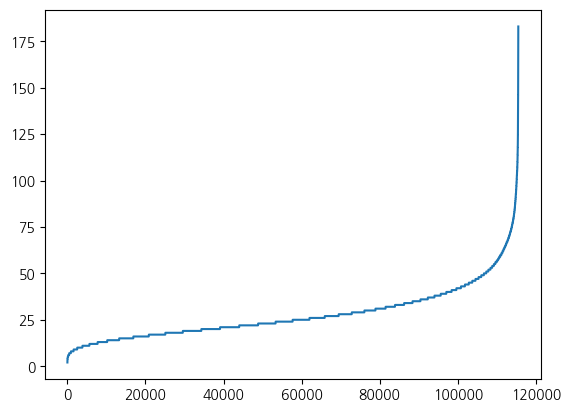

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline 

tokens_len_1.sort()
plt.plot(tokens_len_1)
plt.show()

In [55]:
print(sum([int(l<=40) for l in tokens_len_1]))

98421


In [56]:
# 토큰 수 컨트롤
modified_clean_train_review_1 = [tokens[:40] for tokens in clean_train_review_1]
modified_clean_test_review_1 = [tokens[:40] for tokens in clean_test_review_1]

Type 2: stem=True, remove_stopwords=False

In [94]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_2 = [len(tokens) for tokens in clean_train_review_2]
df_tokens_len_2 = pd.DataFrame(tokens_len_2, columns=['Token Count'])
df_tokens_len_2.describe()

,Token Count
count,115526.000000
mean,27.967644
std,14.818418
min,2.000000
25%,18.000000
50%,25.000000
75%,34.000000
max,183.000000


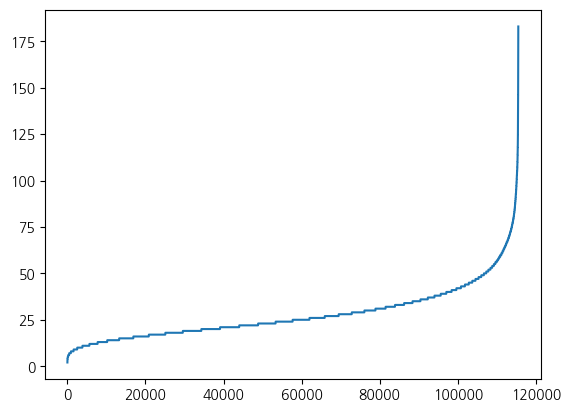

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline 

tokens_len_2.sort()
plt.plot(tokens_len_2)
plt.show()

In [97]:
print(sum([int(l<=40) for l in tokens_len_2]))

98421


In [98]:
# 토큰 수 컨트롤
modified_clean_train_review_2 = [tokens[:40] for tokens in clean_train_review_2]
modified_clean_test_review_2 = [tokens[:40] for tokens in clean_test_review_2]

Type 3: stem=True, remove_stopwords=True

In [105]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_3 = [len(tokens) for tokens in clean_train_review_3]
df_tokens_len_3 = pd.DataFrame(tokens_len_3, columns=['Token Count'])
df_tokens_len_3.describe()

,Token Count
count,115526.000000
mean,25.546128
std,13.501976
min,2.000000
25%,17.000000
50%,22.000000
75%,31.000000
max,170.000000


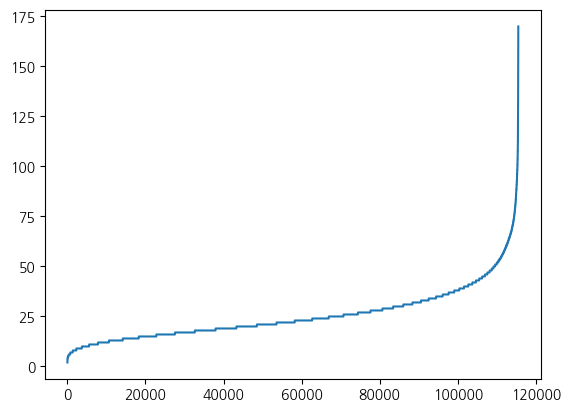

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline 

tokens_len_3.sort()
plt.plot(tokens_len_3)
plt.show()

In [107]:
print(sum([int(l<=40) for l in tokens_len_3]))

102707


In [108]:
# 토큰 수 컨트롤
modified_clean_train_review_3 = [tokens[:40] for tokens in clean_train_review_3]
modified_clean_test_review_3 = [tokens[:40] for tokens in clean_test_review_3]

# Padding

Type 1: stem=False, remove_stopwords=False

In [83]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_1)

X_train_1 = tokenizer.texts_to_sequences(modified_clean_train_review_1)
X_train_1 = pad_sequences(X_train_1, padding='post')

X_test_1 = tokenizer.texts_to_sequences(modified_clean_test_review_1)
X_test_1 = pad_sequences(X_test_1, padding ='post') 

print(X_train_1[:5])

[[  200   561   134    11     3  1647    93 11853  7592 11215    94    16
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 5526  2125    60  2113   282     4    77 17943    18    13    31   166
      2    35    40    22    26   869  2167    59   987   365    12  1035
    252   748   731   249   589    24 10182  2684    41     0     0     0
      0     0     0     0]
 [  146  2017   442    57   142    35   463  1245    16  1164    36    28
    119     3  1775    14   633   107     3   490     1     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [   44    92    44    11     3     5   239   441     1   303   927   520
    212   118   313    23   394     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 1

Type 2: stem=True, remove_stopwords=False

In [99]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_2)

X_train_2 = tokenizer.texts_to_sequences(modified_clean_train_review_2)
X_train_2 = pad_sequences(X_train_2, padding='post')

X_test_2 = tokenizer.texts_to_sequences(modified_clean_test_review_2)
X_test_2 = pad_sequences(X_test_2, padding ='post') 

print(X_train_2[:5])

[[   75   169    30    14     5  1411   105  6594  4774  6322   106    26
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 3803  1775    76    37    11   292     6    56    11     2    19     2
    182     4     3    46    11     3  1054   820  1801 13925    68   919
    365    18   959   271   718    77   267   574    32    47    17    16
      0     0     0     0]
 [  159  1691   434    66    11   155     3   454  1125    26  1061     2
     34   132     5  1513    20    37 13926   119     5   478     1   637
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    3   103     3    14     5    10    48   432     1    97   867   510
    227   152   317    21   251     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 1

Type 3: stem=True, remove_stopwords=True

In [110]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_3)

X_train_3 = tokenizer.texts_to_sequences(modified_clean_train_review_3)
X_train_3 = pad_sequences(X_train_3, padding='post')

X_test_3 = tokenizer.texts_to_sequences(modified_clean_test_review_3)
X_test_3 = pad_sequences(X_test_3, padding ='post') 

print(X_train_3[:5])

[[   68   164    26    12     4  1406    95  6373  4796  6374    97    21
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 3822  1726    32     8   282    49     8     1    16     1   174     3
      2    40     8     2  1044   801  1784 14026    61   908   356    15
    947   704    69   260   558    27    41    14    13     0     0     0
      0     0     0     0]
 [  151  1681   427    60     8   149     2   442  1114    21  1058     1
     29   124     4  1503    17    32 14027   110     4   462   623     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    2    94     2    12     4     7    43   423    90   865   220   144
    309    18   242     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  

# Modeling

Type 1: stem=False, remove_stopwords=False

In [91]:
# 모델 훈련
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=40),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 300)           6000000   
                                                                 
 lstm_6 (LSTM)               (None, 50)                70200     
                                                                 
 dense_6 (Dense)             (None, 3)                 153       
                                                                 
Total params: 6070353 (23.16 MB)
Trainable params: 6070353 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
# 학습
history = model_1.fit(X_train_1, y_train, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
723/723 [==============================] - 114s 157ms/step - loss: 0.4372 - accuracy: 0.8225 - val_loss: 0.3326 - val_accuracy: 0.8676
Epoch 2/3
723/723 [==============================] - 121s 167ms/step - loss: 0.2664 - accuracy: 0.8968 - val_loss: 0.3243 - val_accuracy: 0.8700
Epoch 3/3
723/723 [==============================] - 120s 165ms/step - loss: 0.1972 - accuracy: 0.9244 - val_loss: 0.3753 - val_accuracy: 0.8645


Type 2: stem=True, remove_stopwords=False

In [100]:
# 모델 훈련
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=40),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 300)           6000000   
                                                                 
 lstm_7 (LSTM)               (None, 50)                70200     
                                                                 
 dense_7 (Dense)             (None, 3)                 153       
                                                                 
Total params: 6070353 (23.16 MB)
Trainable params: 6070353 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [130]:
# 학습
history = model_2.fit(X_train_2, y_train, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
723/723 [==============================] - 118s 163ms/step - loss: 0.4564 - accuracy: 0.8127 - val_loss: 0.3570 - val_accuracy: 0.8568
Epoch 2/3
723/723 [==============================] - 125s 173ms/step - loss: 0.3029 - accuracy: 0.8799 - val_loss: 0.3295 - val_accuracy: 0.8675
Epoch 3/3
723/723 [==============================] - 126s 175ms/step - loss: 0.2402 - accuracy: 0.9063 - val_loss: 0.3402 - val_accuracy: 0.8699


Type 3: stem=True, remove_stopwords=True

In [119]:
# 모델 훈련
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=40),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 40, 300)           6000000   
                                                                 
 lstm_11 (LSTM)              (None, 50)                70200     
                                                                 
 dense_11 (Dense)            (None, 3)                 153       
                                                                 
Total params: 6070353 (23.16 MB)
Trainable params: 6070353 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
# 학습
history = model_3.fit(X_train_3, y_train, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
723/723 [==============================] - 131s 177ms/step - loss: 0.4658 - accuracy: 0.8087 - val_loss: 0.3629 - val_accuracy: 0.8520
Epoch 2/3
723/723 [==============================] - 134s 185ms/step - loss: 0.2999 - accuracy: 0.8818 - val_loss: 0.3322 - val_accuracy: 0.8686
Epoch 3/3
723/723 [==============================] - 123s 170ms/step - loss: 0.2380 - accuracy: 0.9079 - val_loss: 0.3521 - val_accuracy: 0.8642


# Test

Type 1: stem=False, remove_stopwords=False

In [132]:
# 테스트 데이터 값 예측
prediction_1 = model_1.predict(X_test_1)
prediction_1

903/903 [==============================] - 13s 15ms/step


array([[1.3750362e-02, 9.0382123e-01, 8.2428351e-02],
       [2.2389850e-05, 4.6234130e-04, 9.9951530e-01],
       [6.1395018e-05, 7.7451486e-04, 9.9916410e-01],
       ...,
       [1.0972546e-01, 8.7968403e-01, 1.0590452e-02],
       [4.6144765e-02, 9.4795710e-01, 5.8980859e-03],
       [9.3517985e-05, 4.5094742e-03, 9.9539703e-01]], dtype=float32)

In [133]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_1 = np.argmax(prediction_1, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_1 = accuracy_score(y_test, predicted_labels_1)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_1 * 100:.2f}%")

테스트 정확도: 86.23%


Type 2: stem=True, remove_stopwords=False

In [134]:
# 테스트 데이터 값 예측
prediction_2 = model_2.predict(X_test_2)
prediction_2

  1/903 [..............................] - ETA: 59s

903/903 [==============================] - 11s 12ms/step


array([[4.2589828e-02, 2.3591381e-01, 7.2149634e-01],
       [4.9365113e-05, 1.1737033e-03, 9.9877697e-01],
       [7.6683849e-02, 8.4578646e-03, 9.1485828e-01],
       ...,
       [3.7901897e-02, 9.5147294e-01, 1.0625091e-02],
       [7.1847015e-03, 9.8590785e-01, 6.9074044e-03],
       [5.8686357e-05, 1.9875816e-03, 9.9795365e-01]], dtype=float32)

In [135]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_2 = np.argmax(prediction_2, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_2 = accuracy_score(y_test, predicted_labels_2)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_2 * 100:.2f}%")

테스트 정확도: 86.90%


Type 3: stem=True, remove_stopwords=True

In [136]:
# 테스트 데이터 값 예측
prediction_3 = model_3.predict(X_test_3)
prediction_3

  1/903 [..............................] - ETA: 52s

903/903 [==============================] - 11s 12ms/step


array([[7.5054280e-03, 9.0829378e-01, 8.4200770e-02],
       [4.5739147e-05, 1.1364823e-03, 9.9881774e-01],
       [3.6879100e-02, 2.3110906e-02, 9.4001001e-01],
       ...,
       [4.7512120e-01, 5.1746160e-01, 7.4172942e-03],
       [4.8783172e-02, 9.4585967e-01, 5.3571495e-03],
       [1.2032554e-04, 3.5209444e-03, 9.9635869e-01]], dtype=float32)

In [137]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_3 = np.argmax(prediction_3, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_3 = accuracy_score(y_test, predicted_labels_3)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_3 * 100:.2f}%")

테스트 정확도: 86.16%
